In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_parquet('df_reponse_daily_train.parquet')
df = df.reset_index()

In [138]:
df

,time,stock_id,liq_weight,mktcap_weight,equal_weight,21d_next_raw,10d_next_raw,5d_next_raw,1d_next_raw,21d_next_mktAdj,...,MOMENTUM,LEVERAGE,VALUE,EARNYLD,GROWTH,LTREV,STREV,industry_code,st_status,price
0,2010-01-04 10:00:00,1,3.093088e+09,7.530677e+10,1.0,-0.109278,-0.105979,-0.054021,-0.047835,-0.047374,...,0.737709,0.557227,-0.306540,-0.655995,0.214168,0.000000,0.572045,28,0.0,24.250000
1,2010-01-04 10:00:00,2,4.916040e+09,1.032883e+11,1.0,-0.108716,-0.051546,-0.032802,-0.035614,-0.046811,...,-0.473381,0.360857,0.466091,0.250722,-0.004936,0.000000,1.424041,11,0.0,10.720141
2,2010-01-04 10:00:00,5,5.239416e+08,5.467715e+09,1.0,-0.090301,0.021739,-0.013378,-0.016722,-0.028396,...,1.227050,-0.792016,-1.179613,-0.736454,-0.944968,0.000000,-0.685017,11,1.0,5.980000
3,2010-01-04 10:00:00,6,6.517194e+08,5.685524e+09,1.0,-0.077609,-0.007136,-0.036574,-0.039251,-0.015705,...,0.396165,1.905245,0.353328,-0.193752,-0.887294,0.000000,1.657673,11,0.0,11.282970
4,2010-01-04 10:00:00,7,1.407934e+08,1.298457e+09,1.0,0.004274,0.096866,0.011396,-0.017094,0.066178,...,0.604593,0.467104,-2.195040,-0.370742,-0.951803,0.000000,0.873514,20,1.0,7.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4496611,2017-11-30 10:00:00,603993,1.945218e+09,1.268403e+11,1.0,-0.043175,-0.047354,-0.094708,-0.036212,-0.018731,...,0.413714,1.035243,-0.735953,-0.342288,-0.516140,0.317234,-0.368143,12,0.0,23.175574
4496612,2017-11-30 10:00:00,603996,2.592166e+08,5.384691e+09,1.0,-0.010033,0.026756,0.008361,0.013935,0.014411,...,-0.395947,0.238730,-1.154499,-0.699089,0.117570,0.775154,-0.585079,18,0.0,27.474264
4496613,2017-11-30 10:00:00,603997,1.910796e+08,7.434000e+09,1.0,-0.039831,-0.003390,-0.013559,-0.012712,-0.015386,...,-0.286645,-1.106616,-1.327366,-0.184245,-0.084308,-0.330599,0.491384,14,0.0,18.072642
4496614,2017-11-30 10:00:00,603998,1.079782e+08,4.955769e+09,1.0,-0.021739,-0.023478,0.049565,-0.028696,0.002705,...,-0.441177,-0.852380,-1.373061,-0.509726,-0.872795,-1.007577,1.828538,4,0.0,45.186621


In [134]:
df_s

,time,stock_id,price
0,2010-01-04 10:00:00,1,24.250000
1,2010-01-04 10:00:00,2,10.720141
2,2010-01-04 10:00:00,5,5.980000
3,2010-01-04 10:00:00,6,11.282970
4,2010-01-04 10:00:00,7,7.020000
...,...,...,...
4496611,2017-11-30 10:00:00,603993,23.175574
4496612,2017-11-30 10:00:00,603996,27.474264
4496613,2017-11-30 10:00:00,603997,18.072642
4496614,2017-11-30 10:00:00,603998,45.186621


In [34]:
df_s = df[['time','stock_id','price']]

In [70]:
df_series = df_s.pivot(index='time', columns='stock_id')

In [139]:
df_series

price                                             \
stock_id                1          2      4      5          6      7        
time                                                                        
2010-01-04 10:00:00  24.250000  10.720141    NaN   5.98  11.282970   7.02   
2010-01-05 10:00:00  23.090000  10.338355    NaN   5.88  10.840106   6.90   
2010-01-06 10:00:00  22.770000  10.278073    NaN   6.14  10.809910   7.25   
2010-01-07 10:00:00  22.740000  10.338355    NaN   5.91  10.729390   7.15   
2010-01-08 10:00:00  22.700000  10.408684    NaN   5.88  10.981017   6.99   
...                        ...        ...    ...    ...        ...    ...   
2017-11-24 10:00:00  41.480688  38.605810  28.70   4.21        NaN    NaN   
2017-11-27 10:00:00  41.628728  39.664016  26.29   4.19        NaN    NaN   
2017-11-28 10:00:00  40.325980  38.344372  26.24   4.22        NaN    NaN   
2017-11-29 10:00:00  40.681275  38.780103  25.49   4.23        NaN    NaN   
2017-11-30 10:00:00  40.266764  40.809367  25.37   4.25        NaN    NaN   

                                                             ...             \
stock_id                8          9      10         11      ...     603987   
time                                                         ...              
2010-01-04 10:00:00        NaN  11.482411  11.97  16.282148  ...        NaN   
2010-01-05 10:00:00        NaN  11.156147  11.55  16.052606  ...        NaN   
2010-01-06 10:00:00        NaN  10.945653  11.56  15.501707  ...        NaN   
2010-01-07 10:00:00        NaN  10.871981  11.71  15.562918  ...        NaN   
2010-01-08 10:00:00        NaN  11.513985  11.27  15.593523  ...        NaN   
...                        ...        ...    ...        ...  ...        ...   
2017-11-24 10:00:00  74.373284  15.013277   5.34  26.986200  ...  19.000717   
2017-11-27 10:00:00  72.631521  15.033241   5.30  27.116884  ...  18.261213   
2017-11-28 10:00:00  72.108992  15.153028   5.17  27.116884  ...  18.351765   
2017-11-29 10:00:00  71.673551  15.192957   5.28  27.394587  ...  18.774338   
2017-11-30 10:00:00  73.589491  15.412566   5.19  27.819309  ...  18.683787   

                                                                        \
stock_id                603988     603989     603990 603991     603993   
time                                                                     
2010-01-04 10:00:00        NaN        NaN        NaN    NaN        NaN   
2010-01-05 10:00:00        NaN        NaN        NaN    NaN        NaN   
2010-01-06 10:00:00        NaN        NaN        NaN    NaN        NaN   
2010-01-07 10:00:00        NaN        NaN        NaN    NaN        NaN   
2010-01-08 10:00:00        NaN        NaN        NaN    NaN        NaN   
...                        ...        ...        ...    ...        ...   
2017-11-24 10:00:00  76.464093  64.487067  34.840076  31.72  20.625615   
2017-11-27 10:00:00  79.536582  63.297032  33.986153  31.80  21.949012   
2017-11-28 10:00:00  79.097655  62.026588  33.815368  31.26  21.464842   
2017-11-29 10:00:00  80.051186  61.222510  33.403475  30.94  22.659127   
2017-11-30 10:00:00  79.990644  61.833609  33.282922  30.31  23.175574   

                                                                 
stock_id                603996     603997     603998     603999  
time                                                             
2010-01-04 10:00:00        NaN        NaN        NaN        NaN  
2010-01-05 10:00:00        NaN        NaN        NaN        NaN  
2010-01-06 10:00:00        NaN        NaN        NaN        NaN  
2010-01-07 10:00:00        NaN        NaN        NaN        NaN  
2010-01-08 10:00:00        NaN        NaN        NaN        NaN  
...                        ...        ...        ...        ...  
2017-11-24 10:00:00  27.198603  17.169010  47.229842  19.061832  
2017-11-27 10:00:00  27.673353  17.888853  45.304499  19.158592  
2017-11-28 10:00:00  27.903071  17.919484  45.540255  19.231163  
2017-11-29

In [136]:
df_series_filled = df_series.fillna(0.001)['price'][11]
df_series_filled

time
2010-01-04 10:00:00    16.282148
2010-01-05 10:00:00    16.052606
2010-01-06 10:00:00    15.501707
2010-01-07 10:00:00    15.562918
2010-01-08 10:00:00    15.593523
                         ...    
2017-11-24 10:00:00    26.986200
2017-11-27 10:00:00    27.116884
2017-11-28 10:00:00    27.116884
2017-11-29 10:00:00    27.394587
2017-11-30 10:00:00    27.819309
Name: 11, Length: 1923, dtype: float64

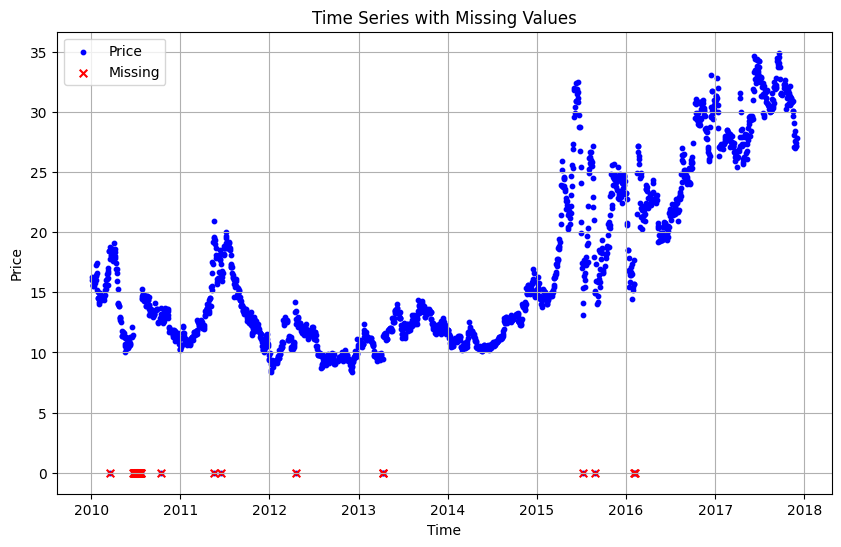

In [137]:
plt.figure(figsize=(10, 6))
plt.scatter(df_series_filled.index, df_series_filled, marker='o', s=10, linestyle='-', color='blue', label='Price')
plt.scatter(df_series_filled[df_series_filled < 0.1].index, df_series_filled[df_series_filled < 0.1], marker='x', s=30, color='red', label='Missing')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Time Series with Missing Values')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
timesteps = []
for i in df_s['stock_id'].unique():
    timesteps.append(len(df_s[df_s['stock_id'] == i]))

In [30]:
len(df_s['time'].unique())

1923

In [29]:
pd.Series(timesteps).describe()

count    3459.000000
mean     1299.975716
std       654.785213
min         1.000000
25%       656.000000
50%      1625.000000
75%      1818.000000
max      1920.000000
dtype: float64

In [3]:
df['stock_id'].nunique()

3459

In [4]:
time_spans = df.groupby('stock_id')['time'].agg(['min', 'max']).reset_index()
count = len(time_spans[(time_spans['max'] > '2017-05') & (time_spans['min'] < '2012')])
count

2260

In [5]:
time_spans[25:]

,stock_id,min,max
25,30,2010-01-04 10:00:00,2017-11-30 10:00:00
26,31,2010-01-04 10:00:00,2017-07-21 10:00:00
27,32,2010-01-04 10:00:00,2017-11-30 10:00:00
28,33,2010-01-04 10:00:00,2017-05-25 10:00:00
29,34,2010-09-03 10:00:00,2017-09-28 10:00:00
...,...,...,...
3454,603993,2012-10-10 10:00:00,2017-11-30 10:00:00
3455,603996,2016-01-12 10:00:00,2017-11-30 10:00:00
3456,603997,2015-03-10 10:00:00,2017-11-30 10:00:00
3457,603998,2014-12-16 10:00:00,2017-11-30 10:00:00


In [27]:
id_filtered = time_spans[(time_spans['max'] > '2017-05-01') & (time_spans['min'] < '2012-01-01')]['stock_id'].reset_index(drop=True)

In [28]:
id_filtered[24:]

24          31
25          32
26          33
27          34
28          35
         ...  
2255    601991
2256    601992
2257    601996
2258    601998
2259    601999
Name: stock_id, Length: 2236, dtype: int64

In [8]:
df['industry_code'].unique()

array([28, 11, 20, 22,  9,  8, 21, 30, 18, 24, 14, 25,  2,  4, 26,  7, 13,
        3,  5, 12, 10,  0,  1, 23, 16, 15, 29, 17, 27,  6, 19],
      dtype=int64)

In [9]:
len(df[df['industry_code']==1]['stock_id'].unique())

138

In [10]:
df.columns

Index(['time', 'stock_id', 'liq_weight', 'mktcap_weight', 'equal_weight',
       '21d_next_raw', '10d_next_raw', '5d_next_raw', '1d_next_raw',
       '21d_next_mktAdj', '10d_next_mktAdj', '5d_next_mktAdj',
       '1d_next_mktAdj', '21d_next_styAdj', '10d_next_styAdj',
       '5d_next_styAdj', '1d_next_styAdj', 'SIZE', 'SIZENL', 'LIQUIDITY',
       'BETA', 'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE', 'EARNYLD', 'GROWTH',
       'LTREV', 'STREV', 'industry_code', 'st_status', 'price'],
      dtype='object')

In [29]:
df_filtered = df[(df['stock_id'].isin(id_filtered))][['time', 'stock_id','liq_weight', 'mktcap_weight', 'equal_weight','SIZE', 'SIZENL',
                                                                                            'LIQUIDITY','BETA', 'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE', 'EARNYLD', 'GROWTH',
                                                                                            'LTREV', 'STREV','price']]
df_filtered = df_filtered[(df_filtered['time'] < '2017-05-01') & ((df_filtered['time'] > '2012-01-01'))].reset_index(drop=True)

In [30]:
df_filtered['stock_id'].nunique()

2260

In [31]:
df[df['stock_id']==5]['time'].min()

Timestamp('2010-01-04 10:00:00')

In [32]:
df_filtered[df_filtered['stock_id']==5]['time'].min()

Timestamp('2012-04-24 10:00:00')

In [48]:
df[df['stock_id']==5][['time','liq_weight']].reset_index(drop=True)[310:320]

,time,liq_weight
310,2011-04-21 10:00:00,227537488.0
311,2011-04-22 10:00:00,232953472.0
312,2011-04-25 10:00:00,234324144.0
313,2011-04-26 10:00:00,232982144.0
314,2011-04-27 10:00:00,224213344.0
315,2011-04-28 10:00:00,221617952.0
316,2011-04-29 10:00:00,211260720.0
317,2012-04-24 10:00:00,81297600.0
318,2012-04-25 10:00:00,100402832.0
319,2012-04-26 10:00:00,149734400.0


In [ ]:
n * k (n=number of stocks, k=number of features)

In [24]:
df_filtered.pivot(index='time', columns='stock_id')

liq_weight                                         \
stock_id                   1             2           4            5        
time                                                                       
2012-01-04 10:00:00  1.973364e+09  1.673385e+09  31668560.0          NaN   
2012-01-05 10:00:00  2.003712e+09  1.673178e+09  31394502.0          NaN   
2012-01-06 10:00:00  1.945220e+09  1.756724e+09  30671936.0          NaN   
2012-01-09 10:00:00  1.917996e+09  1.760657e+09  29923720.0          NaN   
2012-01-10 10:00:00           NaN  1.897350e+09  31245234.0          NaN   
...                           ...           ...         ...          ...   
2017-04-24 10:00:00  3.682046e+09  2.587093e+09         NaN  417426688.0   
2017-04-25 10:00:00  3.594353e+09  2.480674e+09         NaN  406066400.0   
2017-04-26 10:00:00  3.497920e+09  2.428677e+09         NaN  385856416.0   
2017-04-27 10:00:00  3.445996e+09  2.419029e+09         NaN  368934784.0   
2017-04-28 10:00:00  3.369358e+09  2.388029e+09         NaN  350990464.0   

                                                                         \
stock_id                  6           7            8             9        
time                                                                      
2012-01-04 10:00:00   84433368.0         NaN   31605652.0  5.700860e+08   
2012-01-05 10:00:00   84445768.0  32388146.0   30789252.0  5.736074e+08   
2012-01-06 10:00:00   84409200.0  35985528.0   29797260.0  5.588249e+08   
2012-01-09 10:00:00   82504952.0  36504824.0   29043854.0  5.056702e+08   
2012-01-10 10:00:00   88464216.0  37223300.0   30750810.0  5.542092e+08   
...                          ...         ...          ...           ...   
2017-04-24 10:00:00  650063808.0         NaN  663934528.0  1.643258e+09   
2017-04-25 10:00:00  646777280.0         NaN  646774848.0  1.621031e+09   
2017-04-26 10:00:00  626124160.0         NaN  628629376.0  1.577079e+09   
2017-04-27 10:00:00  619160448.0         NaN  604135360.0  1.496253e+09   
2017-04-28 10:00:00  614297920.0         NaN  543295040.0  1.312134e+09   

                                               ...      price            \
stock_id                  10           11      ...     601933    601939   
time                                           ...                        
2012-01-04 10:00:00          NaN  129059624.0  ...  30.326307  5.132729   
2012-01-05 10:00:00          NaN  132175528.0  ...  30.065220  5.143961   
2012-01-06 10:00:00          NaN  125302976.0  ...  29.261874  5.222580   
2012-01-09 10:00:00          NaN  117320104.0  ...  29.422543  5.222580   
2012-01-10 10:00:00          NaN  117472864.0  ...  30.175680  5.301200   
...                          ...          ...  ...        ...       ...   
2017-04-24 10:00:00  488954816.0  503882080.0  ...  52.786996  8.800118   
2017-04-25 10:00:00  472641184.0  493996000.0  ...  52.958105  8.890068   
2017-04-26 10:00:00  455044960.0  485701440.0  ...  54.326973  8.920052   
2017-04-27 10:00:00  435281600.0  479501504.0  ...  53.043659  8.935043   
2017-04-28 10:00:00  410522240.0  472462432.0  ...  52.444779  8.890068   

                                                                          \
stock_id                601958    601988     601989    601991     601992   
time                                                                       
2012-01-04 10:00:00  14.492128  3.364892   8.277835  5.378789   8.357190   
2012-01-05 10:00:00  13.946930  3.376416   7.986818  5.451616   8.085983   
2012-01-06 10:00:00  13.465127       NaN   7.711968  5.524443   7.814777   
2012-01-09 10:00:00  13.465127  3.410987   7.679633  5.430808   7.865000   
2012-01-10 10:00:00  14.568202  3.410987   8.213165  5.410001   8.648487   
...                        ...       ...        ...       ...        ...   
2017-04-24 10:00:00   9.774821  5.363285  12.451831  5.408447  15.043361   
2017-04-25 10:00:00   9.669432  5.408866  12.116202  5.396560  14.811924   
2017-04-26 10:00:00 

In [35]:
df_pivot = df_filtered.pivot(index='time', columns='stock_id')
df_pivot.columns = df_pivot.columns.map(lambda x: f'{x[0]}{x[1]}')
df_final = df_pivot.reset_index().rename(columns={'time': 'date', 'price603668': 'OT'})
df_final.dropna(inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final

,date,liq_weight1,liq_weight2,liq_weight4,liq_weight5,liq_weight6,liq_weight7,liq_weight8,liq_weight9,liq_weight10,...,price601933,price601939,price601958,price601988,price601989,price601991,price601992,price601996,price601998,price601999


In [ ]:
df_final.to_csv('daily_subset.csv',index=False)

In [ ]:
len(df_final)

In [ ]:
df_final.isna().sum()

In [ ]:
df_filtered[df_filtered['price']]